In [1]:
# Parameters
param1 = "value1"
param2 = "value2"


In [2]:
#execution

import json
import os
import uuid
import geopandas as gpd
from io import StringIO
import pystac_client
import rasterio
from rasterio.windows import from_bounds
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np
import boto3
from botocore.exceptions import NoCredentialsError
import time
import pystac_client
from requests.exceptions import HTTPError

# Set environment variable for AWS public datasets
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [3]:
def init_s3_client(endpoint_url, aws_access_key_id, aws_secret_access_key, region_name):
    """
    Initialize an S3 client with the specified configuration.

    Args:
        endpoint_url (str): The complete URL to the S3 service. This is typically the URL to a mock S3 service in a local development environment.
        aws_access_key_id (str): AWS access key ID. For mock services, this can be any string, as authentication is not enforced.
        aws_secret_access_key (str): AWS secret access key. For mock services, this can be any string, as authentication is not enforced.
        region_name (str): The AWS region to use. This can be any valid AWS region string.

    Returns:
        boto3.client: A boto3 S3 client configured to interact with the specified S3 service.
    """
    return boto3.client('s3',
                        endpoint_url=endpoint_url,
                        aws_access_key_id=aws_access_key_id,
                        aws_secret_access_key=aws_secret_access_key,
                        region_name=region_name,
                        use_ssl=False)  # S3Mock and other mock services might not use SSL

In [4]:
s3_client = init_s3_client(endpoint_url='http://s3mock:9090',
                           aws_access_key_id='test',
                           aws_secret_access_key='test',
                           region_name='us-east-1')

In [5]:
def initialize_stac_client(stac_url):
    """
    Initialize and return a STAC client for a given STAC API URL.
    
    Parameters:
    - stac_url (str): The URL of the STAC API.
    
    Returns:
    - A pystac_client.Client object
    """
    client = pystac_client.Client.open(stac_url)
    return client


In [6]:
def query_stac_api(client, bbox, collections, start_date=None, end_date=None, limit=10):
    """
    Query a STAC API for items within a bounding box and date range for specific collections.
    
    Parameters:
    - client: The STAC client initialized with `initialize_stac_client`.
    - bbox (list): The bounding box for the query [min_lon, min_lat, max_lon, max_lat].
    - collections (list): A list of collection IDs to include in the query.
    - start_date (str, optional): The start date for the query (YYYY-MM-DD). Defaults to None.
    - end_date (str, optional): The end date for the query (YYYY-MM-DD). Defaults to None.
    - limit (int): Maximum number of items to return.
    
    Returns:
    - A list of STAC Items that match the query parameters.
    """

    search_params = {
        "bbox": bbox,
        "collections": collections,
        "limit": limit
    }
    if start_date and end_date:
        search_params["datetime"] = f"{start_date}/{end_date}"
    
    search = client.search(**search_params)
    
    items = list(search.items())
    return items


In [7]:
def inspect_stac_item(item):
    """
    Inspects a STAC item and prints out key information to help identify the data type.

    This function iterates over the assets of a given STAC item, printing details such as the
    asset's title, description, media type, and roles. These details can provide insights into
    the nature of the data contained within the item, such as whether it includes satellite imagery,
    elevation data, or other geospatial resources.

    Parameters:
    - item: A STAC item object. This object should conform to the STAC item specification and
            include properties like an ID, datetime, and a dictionary of assets.

    Returns:
    - None: This function does not return any value. It only prints information to the console.
    """
    
    # Print the unique identifier of the STAC item
    print("Item ID:", item.id)
    
    # Print the acquisition date of the data, which is stored in the item's properties
    print("Date:", item.properties.get('datetime'))
    
    # Begin iterating over the assets associated with this STAC item.
    # Assets represent individual data files or resources related to this item.
    print("Assets:")
    for asset_key, asset in item.assets.items():
        # asset_key is the name used to refer to this asset in the STAC item's assets dictionary.
        # asset is the actual asset object, which contains metadata about the data file or resource.
        
        # Print the key of the asset and its title. The title is a human-readable name for the asset.
        # If no title is provided, it defaults to 'No title'.
        print(f"  - {asset_key}: {asset.title or 'No title'}")
        
        # Print a description of the asset, which can provide more context about the data it contains.
        # If no description is provided, it defaults to 'No description'.
        print(f"    Description: {asset.description or 'No description'}")
        
        # Print the media type of the asset, which indicates the format of the data file (e.g., 'image/tiff' for a GeoTIFF file).
        print(f"    Media Type: {asset.media_type}")
        
        # Print the roles associated with this asset. Roles are used to describe the function of the asset,
        # such as whether it's the primary data ('data'), metadata about the item ('metadata'), a thumbnail image ('thumbnail'), etc.
        # The roles are joined by a comma in case there are multiple roles.
        print(f"    Roles: {', '.join(asset.roles)}")


In [8]:
def get_bbox_from_geodf(geojson_data):
    """
    Extract the bounding box from a GeoJSON-like dictionary.
    
    Parameters:
    - geojson_data (dict): The GeoJSON data as a Python dictionary.
    
    Returns:
    - A list representing the bounding box [min_lon, min_lat, max_lon, max_lat].
    """
    gdf = gpd.GeoDataFrame.from_features(geojson_data["features"])
    bbox = list(gdf.total_bounds)
    return bbox


In [9]:
def process_raster_data_with_window(item, asset_key, geojson_bounds):
    asset = item.assets.get(asset_key)
    if asset:
        with rasterio.open(asset.href) as src:
            # Convert the GeoJSON bounds to a rasterio window
            window = from_bounds(*geojson_bounds, transform=src.transform)
            
            # Read the data within the window
            data = src.read(1, window=window)
            
            # Perform your processing here...
            # For example, display the data
            plt.imshow(data, cmap='gray')
            plt.show()

In [10]:
def download_and_plot_dem(item, asset_key='dem'):
    # Access the selected asset based on the asset_key (default is 'dem')
    dem_asset = item.assets[asset_key]
    
    # Access the asset's URL
    dem_url = dem_asset.href
    
    # Use rasterio to open and read the asset
    with rasterio.open(dem_url) as src:
        # Read the first band (assuming it's a single-band raster)
        dem_data = src.read(1)
        
        # Plot the DEM data
        show(dem_data, cmap='terrain', title=f"DEM - {item.id}")

In [11]:
def compute_elevation_statistics(dem_data):
    """
    Compute basic elevation statistics from a digital elevation model (DEM) dataset.

    This function calculates the minimum, maximum, mean, and standard deviation of elevation
    values within the provided DEM data array. It handles the DEM data as a NumPy array,
    which is a common format for raster data in Python.

    Parameters:
    - dem_data (numpy.ndarray): A 2D NumPy array containing elevation data from a DEM raster.
      The array should contain numeric values representing elevation at each cell. No-data
      values should be represented by NaNs in the array to be properly ignored in calculations.

    Returns:
    - dict: A dictionary containing the computed elevation statistics, with keys 'min_elevation',
      'max_elevation', 'mean_elevation', and 'std_dev_elevation'.
    """

    # Compute the minimum elevation, ignoring any NaN values which represent no-data cells
    min_elevation = np.nanmin(dem_data)

    # Compute the maximum elevation, ignoring any NaN values
    max_elevation = np.nanmax(dem_data)

    # Compute the mean elevation, ignoring any NaN values
    mean_elevation = np.nanmean(dem_data)

    # Compute the standard deviation of elevation, ignoring any NaN values
    std_dev_elevation = np.nanstd(dem_data)

    # Construct and return a dictionary containing the computed statistics
    stats = {
        'min_elevation': min_elevation,
        'max_elevation': max_elevation,
        'mean_elevation': mean_elevation,
        'std_dev_elevation': std_dev_elevation
    }

    return stats

In [12]:
# For internal testing
REQUEST = json.dumps({
    'body': {
        "type": "FeatureCollection",
        "name": "dissolved-boundaries",
        "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
        "features": [
            { "type": "Feature", "properties": { "fid": 1 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 116.26012130269045, -29.225295369642396 ], [ 116.261724812149055, -29.241374854584375 ], [ 116.283751968396274, -29.256813692452539 ], [ 116.284342735038919, -29.268250184258388 ], [ 116.292247755352392, -29.265992437426529 ], [ 116.292360282331941, -29.293057573630019 ], [ 116.314865678242256, -29.293523728033122 ], [ 116.326259034921833, -29.293033039128805 ], [ 116.326315298411629, -29.305397680579894 ], [ 116.355065941687045, -29.307016748931797 ], [ 116.355065941687045, -29.306575187382712 ], [ 116.383366477044206, -29.307384715430175 ], [ 116.384322956370426, -29.290407813444993 ], [ 116.387586238777402, -29.282629879611861 ], [ 116.386517232471661, -29.259807919053017 ], [ 116.359201308185533, -29.259488866292969 ], [ 116.359229439930417, -29.259243440415627 ], [ 116.35242155766754, -29.259292525638209 ], [ 116.352140240218716, -29.220237788279107 ], [ 116.302234524787593, -29.223503148505326 ], [ 116.281388901825679, -29.2239696200396 ], [ 116.26012130269045, -29.225295369642396 ] ] ] } }
        ]
    }
})


In [13]:
# GET /hello/world
print(json.dumps({"status": "it works, I think"}))

{"status": "it works, I think"}


Image uploaded to S3: http://localhost:9090/output/test-image.png


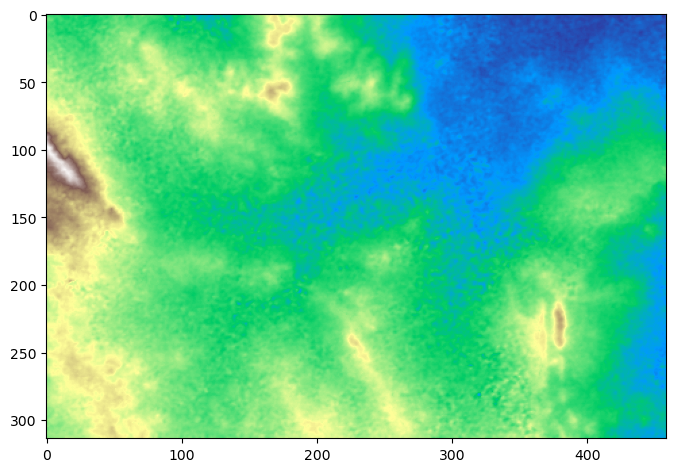

In [14]:
import io
from PIL import Image

req = json.loads(REQUEST)
geojson_data = req['body']  # Directly accessing the 'body' since it's already a dictionary in this mock setup

stac_url_dem = "https://explorer.sandbox.dea.ga.gov.au/stac/"
stac_url_rgb = "https://earth-search.aws.element84.com/v1"
collections_dem = ['ga_srtm_dem1sv1_0']
collections_rgb = ['sentinel-2-l2a']

# Convert the GeoJSON string to a GeoDataFrame
gdf = gpd.read_file(StringIO(json.dumps(geojson_data)))

# Get bounding box from GeoJSON
bbox = get_bbox_from_geodf(geojson_data)

# Initialize STAC clients
#client_dem = initialize_stac_client(stac_url_dem)
client_rgb = initialize_stac_client(stac_url_rgb)

start_date = "2023-01-01"
end_date = "2023-03-01"

# Query STAC catalogs
#items_dem = query_stac_api(client_dem, bbox, collections_dem, None, None)
items_rgb = query_stac_api(client_rgb, bbox, collections_rgb, start_date, end_date)

# dem_results = process_dem_items(items_dem, geojson_data)


# Primary DEM asset URL from the STAC item
#dem_asset = item.assets.get('dem')
#primary_dem_href = dem_asset.href if dem_asset else None

# Fallback DEM URL
fallback_dem_href = 'https://dea-public-data.s3-ap-southeast-2.amazonaws.com/projects/elevation/ga_srtm_dem1sv1_0/dem1sv1_0.tif'


def read_and_process_dem(href):
    with rasterio.open(href) as src:
        # Convert the GeoJSON bounds to a rasterio window
        window = from_bounds(*bbox, transform=src.transform)

        # Read the data within the window
        data = src.read(1, window=window)

        # Remove axes of length one from a.
        return np.squeeze(data)

data = read_and_process_dem(fallback_dem_href)

# image = Image.fromarray(data)

#plt.imshow(data, cmap='terrain')

image = Image.fromarray(data, mode='L')

image_filename = 'test-image.png'

figure = plt.figure(figsize=(8, 6))
plt.imshow(data, cmap='terrain')
#plt.savefig('/tmp/test-image.png', format='png', dpi=300)
#plt.close()

figure.savefig('/tmp/test-image.png', bbox_inches='tight', pad_inches=0.05, transparent=False, dpi=280)

#elevation_stats = compute_elevation_statistics(data)

# Serialize elevation statistics to a JSON string
# elevation_stats_json = json.dumps(elevation_stats)
#elevation_stats_json = json.dumps(elevation_stats, default=lambda obj: float(obj) if isinstance(obj, np.float32) else None)

bucket_name = 'output'
# stats_filename = 'elevation_stats.json'

#s3_client.put_object(Bucket=bucket_name, Key=stats_filename, Body=elevation_stats_json)
#s3_client.upload_fileobj(image_buffer, bucket_name, image_filename)

# Close the image buffer
#image_buffer.close()


# with open('/tmp/image.png', 'wb') as image_file:
#     plt.imsave(image_file, data, cmap='terrain', format='png')

s3_client.upload_file('/tmp/test-image.png', bucket_name, image_filename)

print(f'Image uploaded to S3: http://localhost:9090/{bucket_name}/{image_filename}')


In [15]:
from IPython.display import HTML


url = f'http://localhost:9090/{bucket_name}/{image_filename}'

print(url)

iframe = f'<iframe src="{url}" width="800" height="800"></iframe>'

HTML(iframe)

http://localhost:9090/output/test-image.png


/opt/conda/lib/python3.11/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
